# Goal

This notebook checks model performance on a test set.

**With gratitude to**:
- https://github.com/mattiaspaul/OBELISK
-  https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md

In [1]:
# DATALOADER PARAMS
bs          = 4
nepochs     = 30
num_workers = 2

# PREPROCESS (Isotropic, PadResize)
# iso       = 3
# maxs      = [87, 90, 90]

iso       = 2
maxs      = [144, 144, 144]

# Train:Valid:Test = 60:20:20
train_pct, valid_pct = .60, .20

# Paths

In [2]:
import os

# Paths to (1) code (2) data (3) saved models
code_src    = "/gpfs/home/gologr01"
data_src    = "/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata"
model_src   = "/gpfs/data/oermannlab/private_data/DeepPit/saved_models"

# UMich 
# code src: "/home/labcomputer/Desktop/Rachel"
# data src: "../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/"

deepPit_src = f"{code_src}/DeepPit"
obelisk_src = f"{code_src}/OBELISK"
label_src   = f"{data_src}/samir_labels"
ABIDE_src   = f"{data_src}/ABIDE"

# print
print("Folders in data src: ", end=""); print(*os.listdir(data_src), sep=", ")
print("Folders in label src (data w labels): ", end=""); print(*os.listdir(label_src), sep=", ")
print("Folders in ABIDE src (data wo labels) ", end=""); print(*os.listdir(ABIDE_src), sep=", ")

Folders in data src: ABVIB_49_235.zip, AIBL_2-263.zip, ICMB, ABVIB (1).zip, central.xnat.org, ADNI, PPMI, Oasis_long, samir_labels, ACRIN-FMISO-Brain, LGG-1p19qDeletion, REMBRANDT, ICMB_1005-1297.zip, AIBL, CPTAC-GBM, PPMI_3107-3326.zip, ADNI1_002_0023.zip, TCGA-LGG, ABVIB, ABIDE, AIBL.zip
Folders in label src (data w labels): 50155-50212, PPMI_3107-3326, 50313-50372, 50213-50312, 50373-50453, 50002-50153, AIBL_2-263, ICMB_1005-1297, ADNI1_002_0023, ABVIB_49_235
Folders in ABIDE src (data wo labels) PAD, ABIDE_1, ABIDE


# Imports

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# imports (# Piece)
from transforms import AddChannel, Iso, PadSz,\
                       ZScale, \
                       GNoise, GBlur,\
                       RandBright, RandContrast, \
                       RandDihedral, MattAff
        
from condseg_transforms import (
    AddAtlas, IsoAtlas, 
    ZScaleAtlas, AddChAtlas, 
    MattAffAtlas, ConcatChannel)


from helpers.losses import dice_score, dice_loss, dice_ce_loss, log_cosh_dice_loss, perim_loss

# MONAI
from monai.losses        import DiceLoss
from monai.metrics       import DiceMetric
from monai.networks.nets import VNet, UNet

# Utilities
import os, sys, gc, time, pickle
from pathlib import Path

# Input IO
import SimpleITK as sitk
import meshio

# Numpy and Pandas
import numpy as np
import pandas as pd
from pandas import DataFrame as DF

# Fastai + distributed training
from fastai              import *
from fastai.torch_basics import *
from fastai.basics       import *
from fastai.distributed  import *
from fastai.callback.all import SaveModelCallback
from fastai.callback.tensorboard import TensorBoardCallback

# PyTorch
from torch import nn

# Obelisk
sys.path.append(deepPit_src)
sys.path.append(obelisk_src)

# OBELISK
from utils  import *
from models import obelisk_visceral, obeliskhybrid_visceral

# Helper functions
from helpers.preprocess import get_data_dict_n4, mask2bbox, print_bbox, get_bbox_size, print_bbox_size
from helpers.general    import sitk2np, np2sitk, print_sitk_info, lrange, lmap, numbers2groups, print_hardware_stats
from helpers.viz        import viz_axis, viz_compare_inputs, viz_compare_outputs
from helpers.time       import time_one_batch, get_time_id

# Data

In [5]:
model_fns = sorted(Path(model_src).iterdir(), key=os.path.getmtime, reverse=True)
model_fns = [str(p) for p in model_fns if str(p).endswith(".pth")]
print(*[model_fn[len(model_src):] for model_fn in model_fns], sep="\n")

/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626445575_Fri_Jul_07_2021_hr_10_min_26.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626440381_Fri_Jul_07_2021_hr_08_min_59.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626439241_Fri_Jul_07_2021_hr_08_min_40.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626384969_Thu_Jul_07_2021_hr_17_min_36.pth
/OBELISKHYBRID_log_cosh_dice_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626384854_Thu_Jul_07_2021_hr_17_min_34.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626384611_Thu_Jul_07_2021_hr_17_min_30.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626381455_Thu_Jul_07_2021_hr_16_min_37.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626380514_Thu_Jul_07_2021_hr_16_min

In [6]:
#model_fn = "OBELISKHYBRID_log_cosh_dice_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_67_epochs_30_time_1626043621_Sun_Jul_07_2021_hr_18_min_47.pth"
model_fn = Path(model_fns[0]).name

model_fn = "OBELISKHYBRID_log_cosh_dice_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626384854_Thu_Jul_07_2021_hr_17_min_34.pth"
test_fn  = model_fn[:-4] + "_test_items.pkl"

# print
print(f"Model Name: {model_fn[:-4]}")

Model Name: OBELISKHYBRID_log_cosh_dice_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626384854_Thu_Jul_07_2021_hr_17_min_34


In [7]:
# get parameters

def get_param(fn, prefix, suffix):
    start = fn.index(prefix)
    end   = fn.index(suffix)
    ints = fn[start+len(prefix):end].split("_")
    try:
        if len(ints) == 1: return int(ints[0])
        return [int(x) for x in ints]
    except:
        if len(ints) == 1: return ints[0]
        return ints

model_type = model_fn[0:model_fn.index("_")]
loss_type  = model_fn[model_fn.index("_")+1:model_fn.index("_iso")]

iso_sz     = get_param(model_fn, "iso_", "mm")
maxs       = get_param(model_fn, "pad_", "_bs")
bs         = get_param(model_fn, "bs_", "_test")
nepochs    = get_param(model_fn, "epochs_", "_time")

# get test items
with open(f"{model_src}/{test_fn}", "rb") as input_file:
    test_items = pickle.load(input_file)
    
# get all items
data = {}
folders = os.listdir(label_src)
for folder in folders: data.update(get_data_dict_n4(f"{label_src}/{folder}"))
items = list(data.values())

# print
print(f"Model type: {model_type}. Loss type: {loss_type}. Iso: {iso_sz}. PadResize to: {maxs}. bs = {bs}. nepochs = {nepochs}.")
print(f"Num test items: {len(test_items)}")
print(f"Num items: {len(items)}")

Model type: OBELISKHYBRID. Loss type: log_cosh_dice_loss. Iso: 2. PadResize to: [144, 144, 144]. bs = 2. nepochs = 60.
Num test items: 66
Num items: 335


# Transforms

In [8]:
# tfms
if model_type.startswith("CONDSEG"):
    item_tfms  = [AddAtlas(items), IsoAtlas(iso_sz), PadSz(maxs)]
    batch_tfms = [ZScaleAtlas(), AddChAtlas(), ConcatChannel()]

else:
    item_tfms  = [Iso(iso_sz), PadSz(maxs)]
    batch_tfms = [ZScale(), AddChannel()]

# Dataloaders

In [9]:
# time it
start = time.time()

# tls
tls = TfmdLists(test_items, item_tfms)

# dls
dls = tls.dataloaders(bs=bs, after_batch=batch_tfms, num_workers=num_workers)

# GPU
dls = dls.cuda()

# end timer
elapsed = time.time() - start
print(f"Elapsed time: {elapsed} s for {len(test_items)} items")

Elapsed time: 3.7762720584869385 s for 66 items


In [10]:
# test get one batch
b = dls.one_batch()
print(type(b), b[0].shape, b[1].shape)
print(f"bs = {bs}, n_train = {len(dls.train_ds)}, n_valid = {len(dls.valid_ds)}, n_test_items = {len(test_items)}, n = {len(items)}")

<class 'tuple'> torch.Size([2, 1, 144, 144, 144]) torch.Size([2, 1, 144, 144, 144])
bs = 2, n_train = 66, n_valid = 0, n_test_items = 66, n = 335


# Models

In [11]:
if model_type == "VNET":
    # https://docs.monai.io/en/latest/networks.html#vnet
    device = torch.device("cuda:0")
    model = VNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
    ).to(device)
    
elif model_type == "UNET3D":
    device = torch.device("cuda:0")
    model = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)
    
elif model_type.startswith("CONDSEG"):
    device = torch.device("cuda:0")
    model = UNet(
        dimensions=3,
        in_channels=3,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

elif model_type == "OBELISKHYBRID":
    full_res = maxs
    model    = obeliskhybrid_visceral(num_labels=2, full_res=full_res)
    model.cuda()
    
else:
    pass

# Loss

In [12]:
if loss_type == "log_cosh_dice_loss":
    loss_function = log_cosh_dice_loss
elif loss_type == "DICE":
    loss_function = dice_loss
    
elif loss_type == "perim_loss":
    loss_function = perim_loss
else:
    loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=False)

In [13]:
# check
print("Check")
b = dls.one_batch()
xb,yb = b
print(f"Batch: {len(b)}. xb: {xb.shape}, yb: {yb.shape}")
predb = model(xb)
print(f"Pred batch: {predb.shape}")
loss = loss_function(predb, yb)
print(f"Loss: {loss}")

Check
Batch: 2. xb: torch.Size([2, 1, 144, 144, 144]), yb: torch.Size([2, 1, 144, 144, 144])
Pred batch: torch.Size([2, 2, 144, 144, 144])
Loss: 0.43328097462654114


# Learner

In [14]:
import gc
gc.collect()

70

In [15]:
learn = Learner(dls       = dls, 
                model     = model, 
                loss_func = loss_function,
                metrics   = dice_score)

# load model fname w/o .pth extension
learn.load(f"{model_src}/{model_fn[:-4]}")

In [16]:
# all predictions, 67 items, 4 workers, 15sec
start = time.time()
predictions, targets = learn.get_preds(ds_idx=0)
elapsed = time.time() - start

print(f"Elapsed: {elapsed:0.2f} s for {len(test_items)} items.")

Elapsed: 15.79 s for 66 items.


In [17]:
print(predictions.shape, targets.shape)
print(targets[0].shape, predictions[0].shape)

torch.Size([66, 2, 144, 144, 144]) torch.Size([66, 1, 144, 144, 144])
torch.Size([1, 144, 144, 144]) torch.Size([2, 144, 144, 144])


# Distribution probs

In [18]:
probs = predictions.softmax(1)[:,1]

In [20]:
idx = 0
print("Probs ", probs.shape)

probs = np.asarray(probs)
print("np Probs ", probs.shape)

Probs  (66, 144, 144, 144)
np Probs  (66, 144, 144, 144)


In [21]:
bbox = mask2bbox(np.asarray(torch.argmax(predictions[idx], dim=0)))
print(bbox)

(59, 91, 65, 90, 42, 61)


arr shape  (5, 5, 5) <class 'numpy.ndarray'>
arr shape  <class 'list'>
arr:  <class 'list'> [5.561975e-31, 2.5411402e-31, 3.5593007e-33, 9.4743657e-35, 4.7928267e-36, 6.894671e-21, 5.2164605e-19, 1.2319109e-19, 9.417034e-21, 2.3301136e-22]


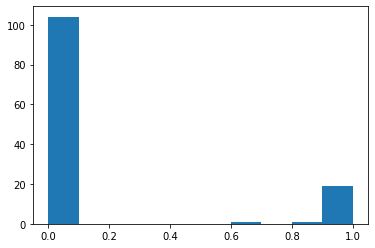

In [25]:
#print(probs_flat[:10]), print(probs[idx][70:75,70:75,50:55].ravel())

arr = probs[idx][70:75,70:75,50:55]

print("arr shape ", arr.shape, type(arr))
arr = list(arr.reshape(-1,))
print("arr shape ",type(arr))

# arr
print("arr: ", type(arr), arr[10:20])

plt.hist(arr)
plt.show()
#ax.set_yscale('log')
#ax.set_title("Distr. Prob(vox=sella)")

n 198180 vs  197074944


Text(0.5, 1.0, 'Distr. Prob(vox=sella)')

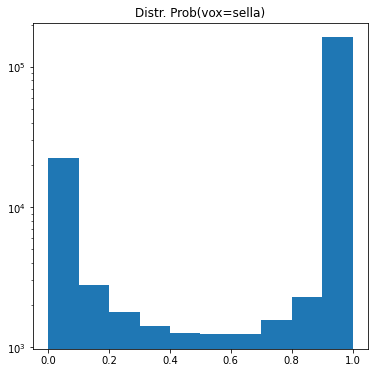

In [29]:
# filter probs > 0.1

eps = 0.001

probs_flat = probs.reshape(-1,)
probs_eps = probs[probs>eps]
print("n", len(probs_eps), "vs ", len(probs_flat))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

ax.hist(probs_eps)
ax.set_yscale('log')
ax.set_title("Distr. Prob(vox=sella)")

In [30]:
# xb,yb = learn.dls.one_batch()
# init_loss = learn.loss_func(learn.model(xb), yb)
# print(init_loss)

# a = learn.model(xb)
# print(a.shape)

# overall_dice = dice_score(predictions, targets)
# print(overall_dice)

# Test set: Prediction Dice Distribution

In [31]:
start = time.time()

indiv_dices = [dice_score(predictions[i].unsqueeze(0), targets[i].unsqueeze(0)) for i in range(len(targets))]
elapsed = time.time() - start

print(f"Elapsed: {elapsed:0.2f} s for {len(targets)} items.")

Elapsed: 29.69 s for 66 items.


Elapsed: 0.05 s for 66 items.


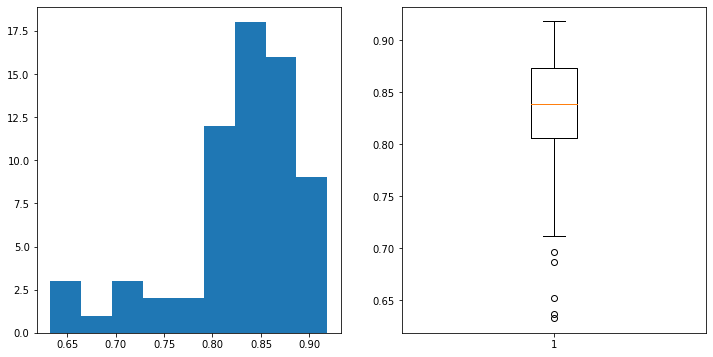

In [59]:
start = time.time()

np_indiv_dices = np.array(sorted([t.item() for t in indiv_dices]))
fig1, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax0.hist(np_indiv_dices, bins="auto")
ax1.boxplot(np_indiv_dices)

elapsed = time.time() - start

print(f"Elapsed: {elapsed:0.2f} s for {len(targets)} items.")

In [65]:
# num dices under 0.6
threshold = 0.7
lows = [(i,dice) for i,dice in enumerate(np_indiv_dices) if dice < threshold]

if len(lows) > 0:
    low_dice_idxs, low_dices = zip(*lows)
else:
    low_dice_idxs, low_dices = [],[]

In [67]:
print(len(low_dices), low_dice_idxs)
print(*[f"Dice {np_indiv_dices[i].item()}, \n fn: {test_items[i][0][len(label_src):]} \n" for i in low_dice_idxs], sep="\n")

5 (0, 1, 2, 3, 4)
Dice 0.6328237056732178, 
 fn: /50313-50372/50333/MP-RAGE/2000-01-01_00_00_00.0/S165330/ABIDE_50333_MRI_MP-RAGE_br_raw_20120830225747452_S165330_I329340_corrected_n4.nii 

Dice 0.6366620063781738, 
 fn: /50213-50312/50259/MP-RAGE/2000-01-01_00_00_00.0/S166122/ABIDE_50259_MRI_MP-RAGE_br_raw_20120905095150458_S166122_I330301_corrected_n4.nii 

Dice 0.6518889665603638, 
 fn: /50155-50212/50157/MP-RAGE/2000-01-01_00_00_00.0/S165692/ABIDE_50157_MRI_MP-RAGE_br_raw_20120831134225513_S165692_I329738_corrected_n4.nii 

Dice 0.6866040825843811, 
 fn: /50313-50372/50343/MP-RAGE/2000-01-01_00_00_00.0/S164388/ABIDE_50343_MRI_MP-RAGE_br_raw_20120830153858349_S164388_I328382_corrected_n4.nii 

Dice 0.6967985033988953, 
 fn: /50213-50312/50299/MP-RAGE/2000-01-01_00_00_00.0/S165419/ABIDE_50299_MRI_MP-RAGE_br_raw_20120830234540483_S165419_I329429_corrected_n4.nii 



# Viz best, worst

In [36]:
gt_bboxs   = [mask2bbox(np.asarray(targets[i].squeeze()))                for i in range(len(targets))]
pred_bboxs = [mask2bbox(np.asarray(torch.argmax(predictions[i], dim=0))) for i in range(len(predictions))]

In [40]:
worst_idx = np.argmin(np_indiv_dices)
best_idx  = np.argmax(np_indiv_dices)
print("Worst. Idx = ", worst_idx, "Dice: ", np_indiv_dices[worst_idx], test_items[worst_idx][0]); print()
print("Best. Idx = ", best_idx, "Dice: ", np_indiv_dices[best_idx], test_items[best_idx][0])

Worst. Idx =  29 Dice:  0.6328237056732178 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50213-50312/50307/MP-RAGE/2000-01-01_00_00_00.0/S165136/ABIDE_50307_MRI_MP-RAGE_br_raw_20120830210457022_S165136_I329146_corrected_n4.nii

Best. Idx =  41 Dice:  0.9182156324386597 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50356/MP-RAGE/2000-01-01_00_00_00.0/S164625/ABIDE_50356_MRI_MP-RAGE_br_raw_20120830173000462_S164625_I328633_corrected_n4.nii


In [41]:
# get dirs
worst_fn = test_items[worst_idx][0]
best_fn  = test_items[best_idx][0]

print(f"Worst fname: {worst_fn[len(label_src):]}"); print()
print(f"best fname: {best_fn[len(label_src):]}")

for fn in (worst_fn, best_fn):
    # get stated direction
    sitk_obj = sitk.ReadImage(fn, sitk.sitkFloat32)
    sitk_dir = sitk_obj.GetDirection()

    # get stated orientation
    orient = sitk.DICOMOrientImageFilter()
    sitk_ori = orient.GetOrientationFromDirectionCosines(sitk_dir)
    
    # print
    print(f"Dir {sitk_dir}, Ori {sitk_ori}")

Worst fname: /50213-50312/50307/MP-RAGE/2000-01-01_00_00_00.0/S165136/ABIDE_50307_MRI_MP-RAGE_br_raw_20120830210457022_S165136_I329146_corrected_n4.nii

best fname: /50313-50372/50356/MP-RAGE/2000-01-01_00_00_00.0/S164625/ABIDE_50356_MRI_MP-RAGE_br_raw_20120830173000462_S164625_I328633_corrected_n4.nii
Dir (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0), Ori LAS
Dir (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0), Ori LAS


In [42]:
# for axis in range(3):
#     viz_compare_inputs(tls[worst_idx], tls[best_idx], axis=axis)

# change orientation

In [43]:
# import nibabel as nb
# from nibabel.orientations import inv_ornt_aff

# # https://github.com/nipy/nipype/blob/70add2941679146307a5bd0769358fc8bcdff17c/nipype/interfaces/image.py#L110
# from nibabel.orientations import (
#             axcodes2ornt, ornt_transform, inv_ornt_aff)

# def get_affine(from_code, to_code, im):
#     orig_ornt = axcodes2ornt(from_code)
#     targ_ornt = axcodes2ornt(to_code)
#     transform = ornt_transform(orig_ornt, targ_ornt)
#     affine_xfm = inv_ornt_aff(transform, im.shape)
    
#     # apply
#     t_arr   = nb.apply_orientation(im, transform)
#     new_aff = affine_xfm.dot(inv_ornt_aff(transform, im.shape))
#     #reoriented = img.__class__(t_arr, new_aff, img.header)
    
#     return t_arr

In [44]:
# worst_mr, worst_seg = tls[worst_idx]
# worst_mr_corr  = get_affine("LAS", "SRA", worst_mr)
# worst_seg_corr = get_affine("LAS", "SRA", worst_seg)

# print("Shapes: mr/seg, corrected mr/seg")
# print(worst_mr.shape, worst_seg.shape, worst_mr_corr.shape, worst_seg_corr.shape)

In [45]:
# # check correction worked
# for axis in range(3):
#     viz_compare_inputs((worst_mr_corr, worst_seg_corr), tls[best_idx], axis=axis)

In [46]:
# worst_item_corr = (worst_mr_corr.copy(), worst_seg_corr.copy())
# print(worst_mr_corr.shape, worst_seg_corr.shape)

# corr_tls = TfmdLists([worst_item_corr], [])
# corr_dls = corr_tls.dataloaders(bs=1, after_batch=batch_tfms, num_workers=num_workers)

# corr_dls = corr_dls.cuda()

# b = corr_dls.one_batch()
# print(b[0].shape, b[1].shape)

In [47]:
# z_worst_mr_corr, z_worst_seg_corr = b[0].squeeze(), b[1].squeeze()
# print(z_worst_mr_corr.shape, z_worst_seg_corr.shape)

In [48]:
# worst_pred_corr = learn.model(b[0])
# print(worst_pred_corr.shape)

In [49]:
# viz_compare_outputs(worst_mr_corr, worst_seg_corr, worst_pred_corr[0].cpu())

# Worst

In [52]:
predictions[worst_idx].shape
targets[worst_idx].shape

torch.Size([1, 144, 144, 144])

In [53]:
# print worst idx file
if model_type.startswith("CONDSEG"):
    print(f"fname: {test_items[worst_idx]}")

    # output: Iso(self.new_sp)(input1), Iso(self.new_sp)(atlas1)
    input1, atlas1 = tls[worst_idx]
    
    # apply ZScale
    worst_mr, worst_seg = ZScale()(input1)
    
    # print
    print(f"Worst mr and seg shape: ", worst_mr.shape, worst_seg.shape)

    # get prediction, ground truth target
    pred, target = predictions[worst_idx], targets[worst_idx].squeeze()

    print("Pred, target shape: ", pred.shape, target.shape)
    print("GT bbox", mask2bbox(np.asarray(target)))
    print("GT bbox and Pred bbox: ", gt_bboxs[worst_idx], pred_bboxs[worst_idx])

    viz_compare_outputs(worst_mr, target, pred)

fname: ('/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50213-50312/50307/MP-RAGE/2000-01-01_00_00_00.0/S165136/ABIDE_50307_MRI_MP-RAGE_br_raw_20120830210457022_S165136_I329146_corrected_n4.nii', '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50213-50312/50307/seg.pt')
Worst mr and seg shape:  torch.Size([144, 144, 144]) torch.Size([144, 144, 144])
Pred, target shape:  torch.Size([2, 144, 144, 144]) torch.Size([144, 144, 144]) torch.Size([144, 144, 144])
Check that target == train_ds[worst_idx] True
GT bbox (59, 80, 70, 87, 49, 65)
GT bbox and Pred bbox:  (59, 80, 70, 87, 49, 65) (60, 80, 64, 89, 50, 64)
Pred: 
Bbox coords: (60, 64, 50) to (80, 89, 64). Size: 20, 25, 14.
Bounding box coord: from location (64, 50) of slice 60 to location (89, 64) of slice 80.
GT: 
Bbox coords: (59, 70, 49) to (80, 87, 65). Size: 21, 17, 16.
Bounding box coord: from location (70, 49) of slice 59 to location (87, 65) of slice 80.
Union: 
Bbox coords: (59, 64, 49) to 

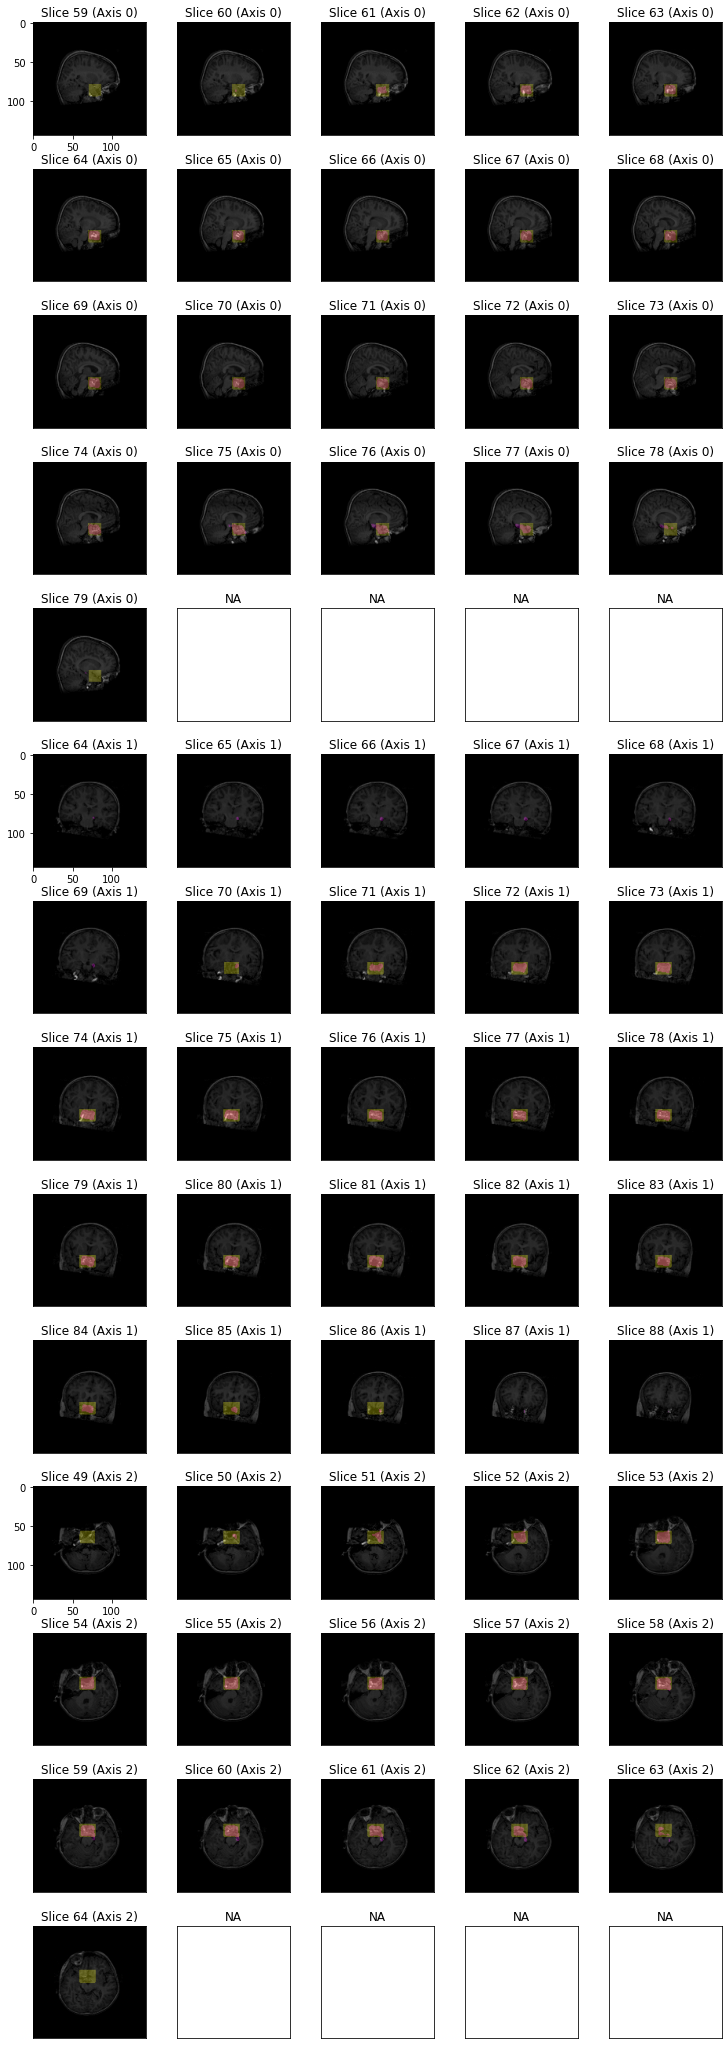

In [54]:
print(f"fname: {test_items[worst_idx]}")

worst_mr, worst_seg = tls[worst_idx]
print(f"Worst mr and seg shape: ", worst_mr.shape, worst_seg.shape)

pred, target = predictions[worst_idx], targets[worst_idx].squeeze()

#pred = torch.argmax(predictions[worst_idx], dim=0)
print("Pred, target shape: ", pred.shape, target.shape, dls.train_ds[worst_idx][0].shape)
print("Check that target == train_ds[worst_idx]", np.array_equal(dls.train_ds[worst_idx][1], target))

mr = dls.train_ds[worst_idx][0]
print("GT bbox", mask2bbox(np.asarray(target)))
print("GT bbox and Pred bbox: ", gt_bboxs[worst_idx], pred_bboxs[worst_idx])

viz_compare_outputs(mr, target, pred)

# Best

In [55]:
print(f"fname: {test_items[best_idx]}")

best_mr, best_seg = tls[best_idx]
print(f"Best mr and seg shape: ", best_mr.shape, best_seg.shape)

pred, target = predictions[best_idx], targets[best_idx].squeeze()

#pred = torch.argmax(predictions[worst_idx], dim=0)
print("Pred, target shape: ", pred.shape, target.shape, dls.train_ds[best_idx][0].shape)
print("Check that target == train_ds[best_idx]", np.array_equal(dls.train_ds[best_idx][1], target))

mr = dls.train_ds[best_idx][0]
print("GT bbox", mask2bbox(np.asarray(target)))
print("GT bbox and Pred bbox: ", gt_bboxs[best_idx], pred_bboxs[best_idx])


fname: ('/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50356/MP-RAGE/2000-01-01_00_00_00.0/S164625/ABIDE_50356_MRI_MP-RAGE_br_raw_20120830173000462_S164625_I328633_corrected_n4.nii', '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50356/seg.pt')
Best mr and seg shape:  torch.Size([144, 144, 144]) torch.Size([144, 144, 144])
Pred, target shape:  torch.Size([2, 144, 144, 144]) torch.Size([144, 144, 144]) torch.Size([144, 144, 144])
Check that target == train_ds[best_idx] True
GT bbox (64, 82, 72, 88, 48, 58)
GT bbox and Pred bbox:  (64, 82, 72, 88, 48, 58) (64, 83, 72, 88, 47, 59)


In [56]:
# 30 sec for 67 test items (2 CPU workers)
learn.validate(ds_idx=0)

(#2) [0.016705578193068504,0.8239968419075012]

# $\Delta$ bbox

In [ ]:
print(predictions.shape, predictions[0].shape, targets[0].shape, torch.argmax(predictions[0], dim=0).shape)

In [ ]:
print(gt_bboxs[0], pred_bboxs[0])

In [ ]:
# compare sizes
def get_bbox_size(imin, imax, jmin, jmax, kmin, kmax): return imax - imin, jmax-jmin, kmax-kmin
gt_bbox_szs   = [get_bbox_size(*gt) for gt in gt_bboxs]
pred_bbox_szs = [get_bbox_size(*pr) for pr in pred_bboxs]

In [ ]:
import pandas as pd
gt_df = pd.DataFrame(gt_bbox_szs, columns =['i', 'j', 'k'])
pred_df = pd.DataFrame(pred_bbox_szs, columns =['i', 'j', 'k'])

In [ ]:
gt_bbox_szs

In [ ]:
pred_bbox_szs

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
gt_df.boxplot(column=['i', 'j', 'k'],   ax=axes[0])
pred_df.boxplot(column=['i', 'j', 'k'], ax = axes[1])

In [ ]:
print(list(pred_bbox_szs[i] for i in low_dice_idxs))

In [ ]:
_, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,4))
pred_df.hist(column=['i', 'j', 'k'], ax=axes[0])
gt_df.hist(column=['i', 'j', 'k'], ax=axes[1])

In [ ]:
def bbox_missing(gt_bbox, pred_bbox):
    # for i_min: missing if gt < pred
    # for i_max: missing if gt > pred
    mins = [max(pred_bbox[i] - gt_bbox[i], 0) for i in (0, 2, 4)]
    maxs = [max(gt_bbox[i] - pred_bbox[i], 0) for i in (1, 3, 5)]
    missing = [x for t in zip(mins, maxs) for x in t]
    return missing

In [ ]:
# test
print(bbox_missing((0,1,2,3,4,5), (0,2,2,3,4,5)))
print(bbox_missing((0,1,2,3,4,5), (1,2,2,3,4,5)))
print(bbox_missing((0,1,2,3,4,5), (-2,2,2,3,4,5)))

In [ ]:
missings = [bbox_missing(gt, pred) for gt, pred in zip(gt_bboxs, pred_bboxs)]

In [ ]:
missings_df = pd.DataFrame(missings, columns =['imin', 'imax', 'jmin', 'jmax', 'kmin', 'kmax'])

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

missings_df.hist(column=['imin', 'imax', 'jmin', 'jmax', 'kmin', 'kmax'], ax=axes[0])
missings_df.boxplot(column=['imin', 'imax', 'jmin', 'jmax', 'kmin', 'kmax'], ax=axes[1])

In [ ]:
for col in ['imin', 'imax', 'jmin', 'jmax', 'kmin', 'kmax']:
    nonzero = [v for v in missings_df[col].values if v != 0]
    max_nonzero = max(nonzero) if len(nonzero) > 0 else "NA"
    print(f"{col}: n = {len(nonzero)}, max diff = {max_nonzero}")

# Resize Pred

In [ ]:
# pad to new size
class ReverseTfm(ItemTransform):
    split_idx = None
    
    def __init__(self, iso_sz, const_sz):
        self.iso_sz   = iso_sz
        self.const_sz = const_sz
    
    def encodes(self, item):
        
        # decode item
        pred, im_path = item
        
        # Get shape post-Iso
        mr = sitk.ReadImage(im_path, sitk.sitkFloat32)

        # iso resize
        orig_sp = mr.GetSpacing()
        orig_sz = mr.GetSize()
        new_sz = [int(round(osz*ospc/self.iso_sz)) for osz,ospc in zip(orig_sz, orig_sp)]
        
        # Pads used to go from iso_sz => const_sz
        pad = [x-y for x,y in zip(self.const_sz, new_sz)]
        pad = [a for amt in pad for a in (amt//2, amt-amt//2)]
        pad.reverse()
        
        # Undo pad: const_sz => new_sz
        shape0, shape1, shape2 = pred.shape
        a,b,c,d,e,f            = pad
        pred_no_pad = pred[e:shape0-f, c:shape1-d, a:shape2-b]

        # Undo iso (add batch dim for interpolate)
        while pred_no_pad.ndim < 5: 
            pred_no_pad = pred_no_pad.unsqueeze(0)
            
        return F.interpolate(pred_no_pad.float(), size = orig_sz, mode = 'nearest').squeeze().long()


In [ ]:
pred = predictions[0]
pred_mk   = torch.argmax(pred, dim=0)
nii = test_items[0][0]

print(pred_mk.shape, nii, sep="\n")

In [ ]:
im_path, segm_path = test_items[0]
orig_mk = torch.load(f"{str(Path(segm_path).parent)}/seg.pt").float()

RTfm = ReverseTfm(iso_sz = iso_sz, const_sz = maxs)
rev_pred = RTfm((pred_mk, nii))
print(f"Orig mask shape: {orig_mk.shape}, Reversed Iso({iso_sz} shape: {rev_pred.shape})")
print("Orig mask", mask2bbox(np.asarray(orig_mk)))
print("Pred mask", mask2bbox(np.asarray(rev_pred)))

# End

In [ ]:
print("Done")